# Project 2: Image Stitcher
## Assigned: 02.01.2019
## Due Date: TBD (probably 02.20.2019)

Panoramic photography is ubiquitous, with nearly every digital camera having a mode dedicated to doing it.  Here's an example from the Italian Alps:
<img src="pano.jpg">
Note the extreme aspect ratio: much larger than the 4:3 or 3:2 that is typical of most cameras; suffice to say, the camera that stook this picture did not have a sensor that was this wide.  So how are these things made?  Stated simply, multiple images are taken, mutually identifiable points are located in each of these images, and the images are warped such that these points are coincident.  The matching stage might look like this:
<img src="office.jpeg">

For this project, you will code your own image stitcher from scratch.  Despite the conceptual simplicity of this operation, there are a surprising number of challenges that need to be addressed.  A general framework for a stitcher might look like this:

In [103]:
import skimage.transform as skt
import matplotlib.pyplot as plt
import numpy as np

class Stitcher(object):
    def __init__(self,image_1,image_2):
        self.images = [image_1,image_2]
        
    def gaussian(self, sz, sigma):
        out = np.zeros((sz, sz))
        ofs = sz // 2
        for j in range(sz):
            for k in range(sz):
                m, n = j - ofs, k - ofs
                out[j, k] = np.exp(-(m*m + n*n)/(2*sigma*sigma))
        return out/out.sum()

    def d_hat(self, d):
        return (d - d.mean()) / np.std(d, ddof=1)

    def err(self, d0, d1):
        out = (d1 - d0)**2     
        return out.sum()
    
    def unpack(self, ls):
        x = []; y = []
        for e in ls:
            x.append(e[0])
            y.append(e[1])
        return np.asarray(x), np.asarray(y)
    
    def residual(self, up, u, vp, v):
        a = (up-u)**2
        b = (vp-v)**2
        return np.sqrt(a + b)
    
    def is_max(self, H, i, j):
        center_val = H[i, j]
        all_i = [i-1, i, i+1, i-1, i+1, i-1, i, i+1]
        all_j = [j-1, j-1, j-1, j, j, j+1, j+1, j+1]
        if np.all(H[all_i, all_j] < center_val):
            return True
        return False

    def local_max(self, H):
        x = []
        y = []
        for i in range(H.shape[0]):
            for j in range(H.shape[1]):
                try:
                    if self.is_max(H, i, j):
                        x.append(i)
                        y.append(j)
                except IndexError as e:
                    continue
        return x, y
    
    def adaptive_suppression(self, H, x, y, n=100, c=0.9):
        '''  Pretty garbage algorithm. Some
        sort of nearest-neighbor algorithm could be much
        more efficient. TODO: Add kd tree.'''
        dist = []
        for x0, y0 in zip(x, y):
            v = H[y0, x0]
            d = np.inf 
            for x1, y1 in zip(x, y):
                if c*H[y1, x1] > v:
                    dd = abs(x1 - x0) + abs(y1 - y0) 
                    if dd < d:
                        d = dd
            dist.append(d)
        ind = np.argsort(dist) 
        ind = ind[-n:]
        x = np.asarray(x)
        y = np.asarray(y)
        return y[ind], x[ind]

    def convolve(self, g, h, step=1):
        '''Note to self: Don't use np.mat with
           regular ndarrays. It results in
           bizarre performance. '''
        out = np.zeros((g.shape))
        k = h.shape[0]
        ofs = k // 2 
        for i in range(k, g.shape[0], step):
            for j in range(k, g.shape[1], step):
                sub_img = g[i-k:i, j-k:j]
                t = sub_img * h
                out[i-ofs, j-ofs] = t.sum()
        return out
        
    def find_keypoints(self, I, gauss_size, gauss_sigma):
        """
        Step 1: This method locates features that are "good" for matching.  To do this we will implement the Harris 
        corner detector
        """
        sobel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

        I_u = self.convolve(I, sobel)
        I_v = self.convolve(I, sobel.T)

        w = self.gaussian(gauss_size, gauss_sigma)

        I_uu = self.convolve(np.multiply(I_u, I_u), w)
        I_vv = self.convolve(np.multiply(I_v, I_v), w)
        I_uv = self.convolve(np.multiply(I_u, I_v), w)

        H = np.divide((np.multiply(I_uu, I_vv) - np.multiply(I_uv, I_uv)), (I_uu + I_vv))
        H[np.isnan(H)] = 0
        
        return H
        
    def generate_descriptors(self, I, x, y, ks=21):
        """
        Step 2: After identifying relevant keypoints, we need to come up with a quantitative description of the 
        neighborhood of that keypoint, so that we can match it to keypoints in other images.
        """
        '''x, y are lists of keypoints.'''
        assert len(x) == len(y)
        ofs = ks // 2
        out = []
        x_out = []
        y_out = []
        for xx, yy in zip(x, y):
            sub = I[xx-ofs:xx+ofs+1, yy-ofs:yy+ofs+1] 
            if sub.shape[0] == ks and sub.shape[1] == ks: 
                x_out.append(xx)
                y_out.append(yy)
                out.append(sub)
        return np.stack(out), np.asarray(y_out), np.asarray(x_out)
        
    def match_keypoints(self, d1, d2, x1, y1, x2, y2, r=0.7):
        """
        Step 3: Compare keypoint descriptions between images, identify potential matches, and filter likely
        mismatches
        """
        out_1 = []
        out_2 = []
        for d, xx1, yy1 in zip(d1, x1, y1):
            d_h = self.d_hat(d)
            mn = np.inf
            mn2 = np.inf
            jj = 0
            for dd, xx2, yy2 in zip(d2, x2, y2):
                dd_h = self.d_hat(dd)
                e = self.err(d_h, dd_h)
                if e < mn2:
                    mn2 = e
                    if e < mn:
                        mn2 = mn
                        mn = e
                        jj = (xx2, yy2)
            if mn < r*mn2:
                out_1.append((xx1, yy1))
                out_2.append(jj)
        return np.asarray(out_1), np.asarray(out_2)
        
    def find_homography(self, pts1, pts2):
        """
        Step 4: Find a linear transformation (of various complexities) that maps pixels from the second image to 
        pixels in the first image
        """
        # split coordinates into lists
        u1 = pts1[:,0]
        v1 = pts1[:,1]
        u2 = pts2[:,0]
        v2 = pts2[:,1]

        # initialize A matrix
        n = len(pts1)
        A = np.zeros(shape=(2*n,9))
        i = 0

        # add rows for each point match
        for j in range(0, 2*n, 2):
            A[j] = [0, 0, 0, -u1[i], -v1[i], -1, v2[i]*u1[i], v2[i]*v1[i], v2[i]]
            A[j+1] = [u1[i], v1[i], 1, 0, 0, 0, -u2[i]*u1[i], -u2[i]*v1[i], -u2[i]]
            i += 1

        # print resulting matrix
        # print(A, '\n')

        # solve the svd for the nullspace
        U,Sigma,Vt = np.linalg.svd(A)

        # return nullspace
        return Vt[-1]
    
    def RANSAC(self, n_iter, pts1, pts2, sample_size, min_inliers, r=5):
        ''' pts1: np.array with shape (n_matches, 2) '''
        H_best = None
        inliers = []
        for m in range(n_iter):
            indices = np.random.choice(pts1.shape[0], size=sample_size, replace=False)
            indices = sorted(indices)

            # split the lists into a sample and the complement
            samp1 = np.zeros(shape=(sample_size, 2))
            samp2 = np.zeros(shape=(sample_size, 2))
            n1 = np.zeros(shape=(pts1.shape[0]-sample_size, 2))
            n2 = np.zeros(shape=(pts2.shape[0]-sample_size, 2))
            j = 0
            k = 0
            for i in range(pts1.shape[0]):
                if i in indices:
                    samp1[j] = pts1[i]
                    samp2[j] = pts2[i]
                    j += 1
                else:
                    n1[k] = pts1[i]
                    n2[k] = pts2[i]
                    k += 1

            H_maybe = self.find_homography(samp1, samp2)
            H_maybe = np.reshape(H_maybe, (3, 3))

            n1_with_ones = np.hstack((n1, np.ones((n1.shape[0], 1))))

            Xprime = H_maybe @ n1_with_ones.T # predict n1's points based on H_maybe, compare to locations in n2.
            Xprime = Xprime.T
            Xprime = Xprime[:, :2] / Xprime[:, 2][:, np.newaxis]
            sub_inliers = []
            for pair1, pair2 in zip(Xprime, n2):
                #print(pair1, pair2)
                test_r = self.residual(pair1[0], pair2[0], pair1[1], pair2[1])

                #print('Residual:', test_r, '\n')

                if  test_r < r:
                    #print(pair1, pair2)
                    sub_inliers.append((pair1, pair2))

            if len(sub_inliers) > len(inliers) and len(sub_inliers) >= min_inliers:
                inliers = sub_inliers
                H_best = H_maybe

        return H_best, np.array(inliers)
        
    def stitch(self, H_best, i1, i2, ofs):
        """
        Step 5: Transform second image into local coordinate system of first image, and (perhaps) perform blending
        to avoid obvious seams between images.
        """
        
        # Create a projective transform based on the homography matrix $H$
        proj_trans = skt.ProjectiveTransform(H_best)
        proj_trans2 = skt.ProjectiveTransform(np.linalg.inv(H_best))

        # Warp the image into image 1's coordinate system
        im_trans2 = skt.warp(i2,proj_trans2)
        im_trans = skt.warp(i1,proj_trans)
        
        return np.concatenate((im_trans, im_trans2[:, ofs:]), axis=1)
        

We will populate these functions over the next several weeks, a process that will involve delving into some of the most elementary operations in digital signal processing.  

As a test case, apply your stitcher to at least four overlapping images that you've taken.  With a stitcher that works on two images, more images can be added by applying the method recursively.

In [104]:
i2 = plt.imread('n1_small.jpg')
i1 = plt.imread('n2_small.jpg')

i1 = i1.mean(axis=2)
i2 = i2.mean(axis=2)

myStitcher = Stitcher(i1, i2)

C:\Users\nohbo\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide


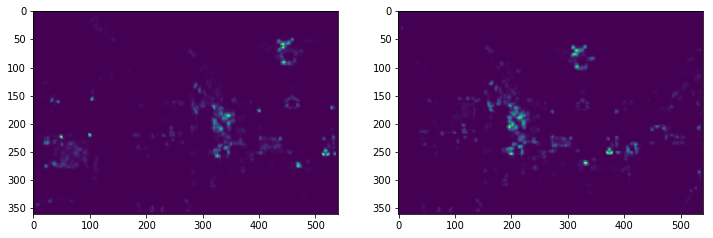

In [105]:
# Step 1: Find keypoints (Harris responses)
gauss_size = 9
gauss_sigma = 2

h1 = myStitcher.find_keypoints(i1, gauss_size, gauss_sigma)
h2 = myStitcher.find_keypoints(i2, gauss_size, gauss_sigma)

fig, axs = plt.subplots(ncols=2, figsize=(12, 8))
axs[0].imshow(h1)
axs[1].imshow(h2)
plt.show()

In [ ]:
# Step 2: filter the harris responses and generate descriptors
x1, y1 = myStitcher.local_max(h1)
x2, y2 = myStitcher.local_max(h2)
x1, y1 = myStitcher.adaptive_suppression(h1, y1, x1)
x2, y2 = myStitcher.adaptive_suppression(h2, y2, x2)

d1, out_x1, out_y1 = myStitcher.generate_descriptors(i1, x1, y1)
d2, out_x2, out_y2 = myStitcher.generate_descriptors(i2, x2, y2)

In [ ]:
# Step 3: Find matching keypoints, filtered with a ratio value of r=0.7
threshold = 0.7
ix1, ix2 = myStitcher.match_keypoints(d1, d2, out_x1, out_y1, out_x2, out_y2, threshold)

match_x1, match_y1 = myStitcher.unpack(ix1)
match_x2, match_y2 = myStitcher.unpack(ix2)
match_x2 += i1.shape[1]

out_im = np.concatenate((i1, i2), axis=1)
plt.figure(figsize=(15, 12))
plt.imshow(out_im, cmap='gray')
for x, y, xx, yy in zip(match_x1, match_y1, match_x2, match_y2):
    plt.plot([x, xx], [y, yy])
plt.show()

In [ ]:
# Step 4: Calculate the homography mapping
n_iter = 1000

match_x2 -= i1.shape[1]
pts1 = np.vstack((match_x1, match_y1)).T
pts2 = np.vstack((match_x2, match_y2)).T

H_best, inliers = myStitcher.RANSAC(n_iter, pts1, pts2, 4, 3)

print('\n', H_best, '\n\n', inliers)

In [ ]:
# Step 5: Stitch using the best transform
# The offset was chosen by eye, but may be calculated keeping track of where the corners are transformed.
# Warps were applied to both sides, however it seems the homographies are still not that good.
ofs = 120
final = myStitcher.stitch(H_best, i1, i2, ofs)

plt.imshow(final, cmap='gray')
plt.show()